# Import Library & Set Globals

In [5]:
# base
import os
import sys
import warnings
import logging
logging.basicConfig(level='INFO')
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

# single cell
import scanpy as sc
import decoupler as dc
import liana as li
from liana.method import cellphonedb
from pacmap import LocalMAP

# custom
sys.path.append('../..')
from py import *

/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.


In [6]:
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from py.R import get_converter,R_preload
converter = get_converter()

# R_preload()
%load_ext rpy2.ipython

In [10]:
%matplotlib inline
study = "paper_processed_FULL"
R_converted = False

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ['scDblFinder','DoubletFinder','doubletdetection','scrublet']

# Subclustering

In [11]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

## Macrophages

In [12]:
# subset
adata_macros = adata[adata.obs["cell_type"] == "Macrophage"].copy()
del adata_macros.uns, adata_macros.varm, adata_macros.obsp
sc.pp.filter_cells(adata_macros, min_genes=200)
sc.pp.filter_genes(adata_macros, min_cells=5)
Visualize(adata_macros,"_macro")

Starting UMAP...
Starting LocalMAP...


AnnData object with n_obs × n_vars = 15063 × 18787
    obs: 'Identifier', 'Groups', 'Experiment', 'Condition', 'Sample Type', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'predicted_doublet-scDblFinder', 'doublet_score-scDblFinder', 'predicted_doublet-DoubletFinder', 'doublet_score-DoubletFinder', 'predicted_doublet-doubletdetection', 'doublet_score-doubletdetection', 'predicted_doublet-scrublet', 'doublet_score-scrublet', 'leiden_doublets', 'manual_doublet', 'leiden', 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'n_cells'
    uns: 'neighbors', 'UMAP_macro'
    obsm: 'LocalMAP', 'MSigDB-M2-CP_padj_ulm', 'MSigDB-M2-CP_score_ulm', 'MSigDB-M3_padj_ulm', 'MSigDB-M3_score_ulm', 'MSigDB-M5-GO_padj_ulm', 'MSigDB-M5-GO_score_ulm', 'MSigDB-M7_padj_ulm', 'MSigDB-M7_score_ulm', 'MSig

Category Groups has 4 groups!


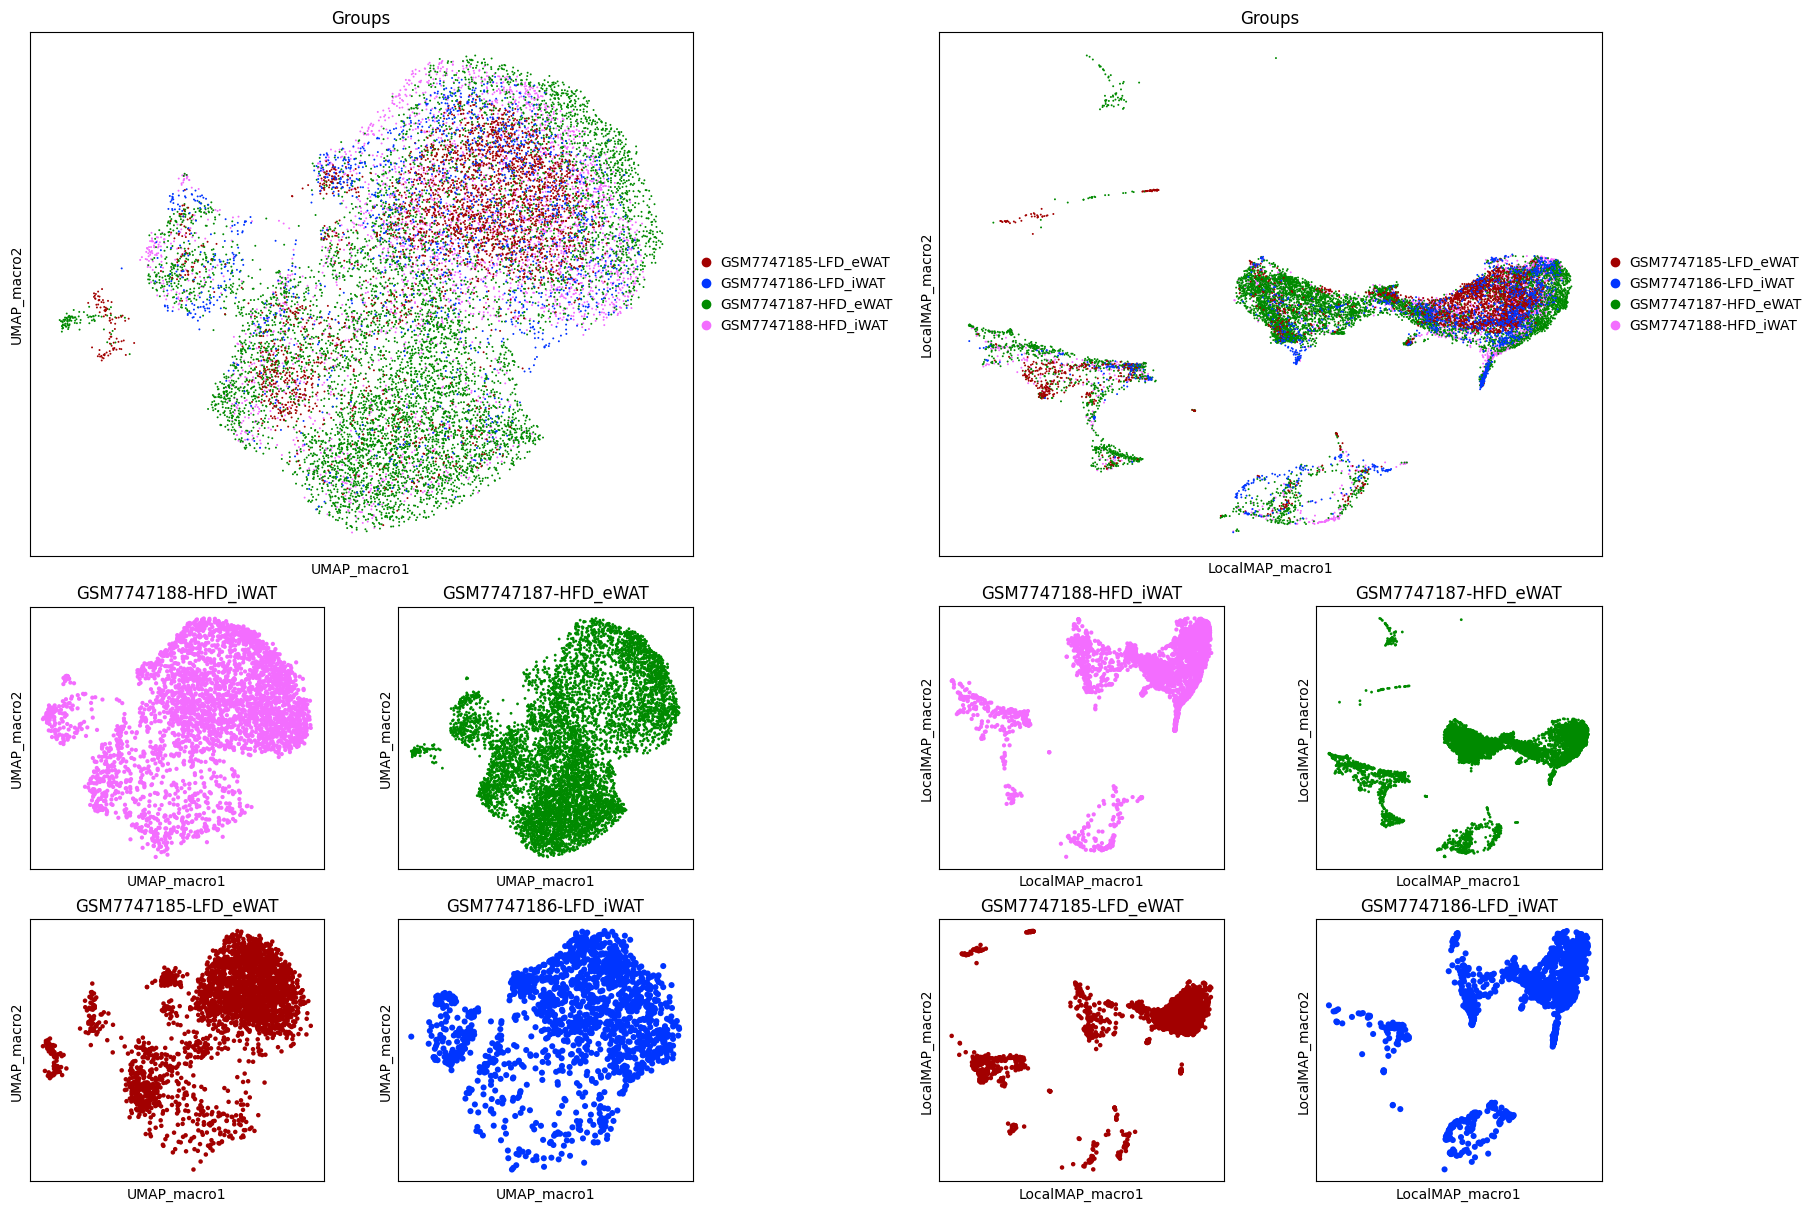

In [13]:
# integration check
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata_macros, "Groups", f, embeddings=["UMAP_macro", "LocalMAP_macro"], nrow=2, ncol=2)

#### Clusters

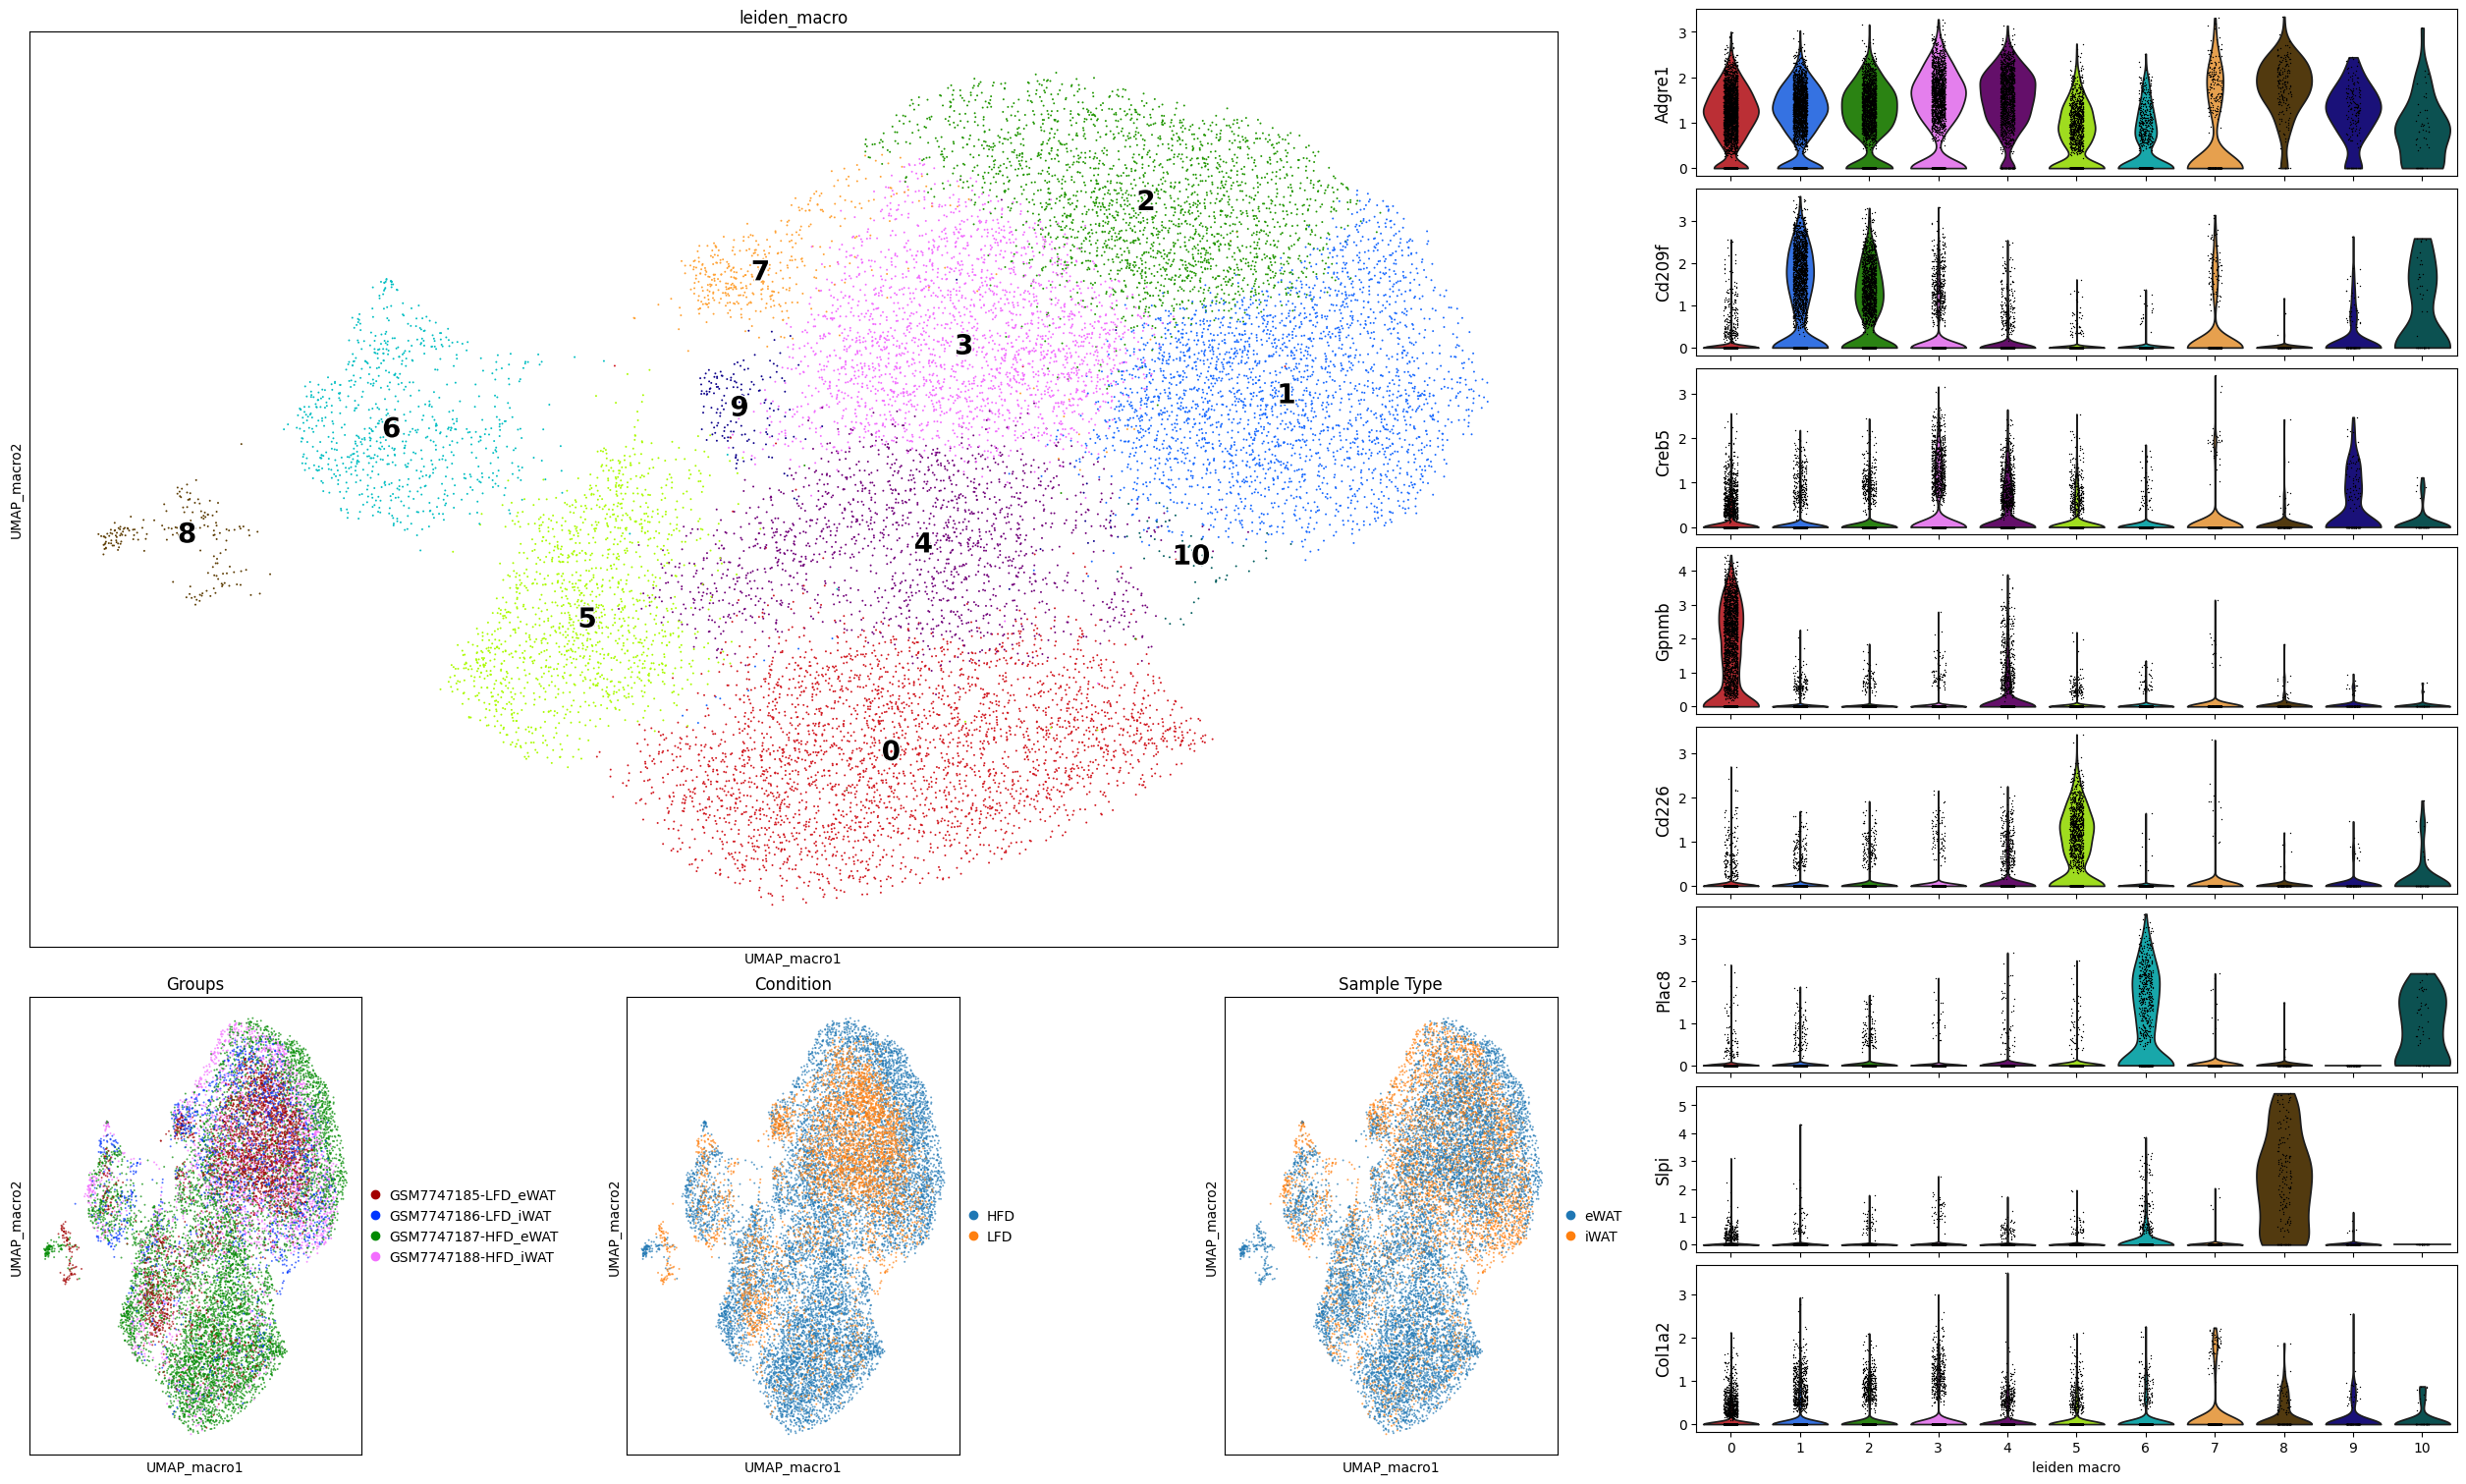

In [14]:
# cluster
recluster = True
key = "leiden_macro"

if recluster is True:
    sc.tl.leiden(adata_macros, resolution=0.5, key_added='leiden_macro')
    # order_obs(adata_macros,"leiden_macro",pd.Series([6,0,2,1,5,3,4,7]).astype(str))

# figure prep
cluster_c = color_gen(adata_macros.obs[key])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "UMAP_macro" # "LocalMAP_macro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_macros, basis=embedding, color=[key], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_macros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_macros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_macros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
cluster_violinplot(adata_macros, markers, key, sf[1])

#### Annotations

In [ ]:
adata_macros.obs["leiden_macro_group"] = adata_macros.obs["leiden_macro"].map(
    {'6' : '1', '0' : '1',
     '1' : '2', '2' : '2',  '3' : '2', '5' : '2',
     '4' : '3',
     '7' : '4',
     })

adata_macros.obs["leiden_macro_group"]

In [ ]:
# reannotate
adata_macros.obs["leiden_macro_group"] = adata_macros.obs["leiden_macro"].map(
    {'6' : 1, '0' : 1,
     '1' : 2, '2' : 2,  '3' : 2, '5' : 2,
     '4' : 3,
     '7' : 4,
     }).astype(str)
order_obs(adata_macros,"leiden_macro_group",pd.Series(np.arange(1,5)).astype(str))

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_macros, "Groups", "leiden_macro_group", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_macros, "Groups", "leiden_macro_group", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_macros, "leiden_macro_group", "Groups", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_macros, "leiden_macro_group", "Groups", pct=True, ax=axs[1])

In [ ]:
# figure prep
groupname = "leiden_macro_group"
cluster_c = color_gen(adata_macros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "UMAP_macro" # "LocalMAP_macro" # "UMAP_macro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_macros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_macros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_macros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_macros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Adgre1", "Cd209f", "Creb5", "Gpnmb", "Cd226", "Plac8", "Slpi", "Col1a2"]
cluster_violinplot(adata_macros, markers, groupname, sf[1])

In [ ]:
# our custom markers, grouped by Groups
f = plt.figure(figsize=(20,20),layout="constrained")
clusters = adata_macros.obs['leiden_macro_group'].cat.categories
cs = color_gen(adata.obs['Groups'],adata.obs['Groups'].cat.categories)
sf = f.subfigures(2,len(clusters))

# CX3CR1, CD206, Arg1, TIM4, CD9, TREM2
markers2 = ["Cx3cr1", "Mrc1", "Arg1", "Timd4", "Cd9", "Trem2"]
print(adata_macros.var_names[adata_macros.var_names.isin(markers2)])

for n,cluster in enumerate(clusters):
    cluster_adata = adata_macros[adata_macros.obs['leiden_macro_group'] == cluster]
    cluster_violinplot(cluster_adata, markers2, "Groups", sf[0,n])

    ax = sf[1,n].subplots(1,1)
    crosstab_counts = pd.crosstab(adata_macros.obs["leiden_macro_group"], adata_macros.obs["Groups"])
    crosstab_counts.loc[cluster][crosstab_counts.loc[cluster] > 0].plot(kind="bar", color=cs[crosstab_counts.loc[cluster] > 0], ax=ax)
    ax.tick_params(axis='x', rotation=0)

    sf[0,n].suptitle(f"Cluster {cluster}")

#### Feature Plots

In [ ]:
flow_markers = ["Lyve1", "H2-Ab1", "Mgl2", "Cx3cr1", "Mrc1"]
sc.pl.embedding(adata_macros, basis="UMAP_macro", color=flow_markers + ["leiden_macro_group"], layer='normalized')

In [ ]:
sc.pl.embedding(adata_macros, basis="UMAP_macro", color=["Pecam1", "Cdh5", "Cdh13"], layer='normalized', ncols=5)

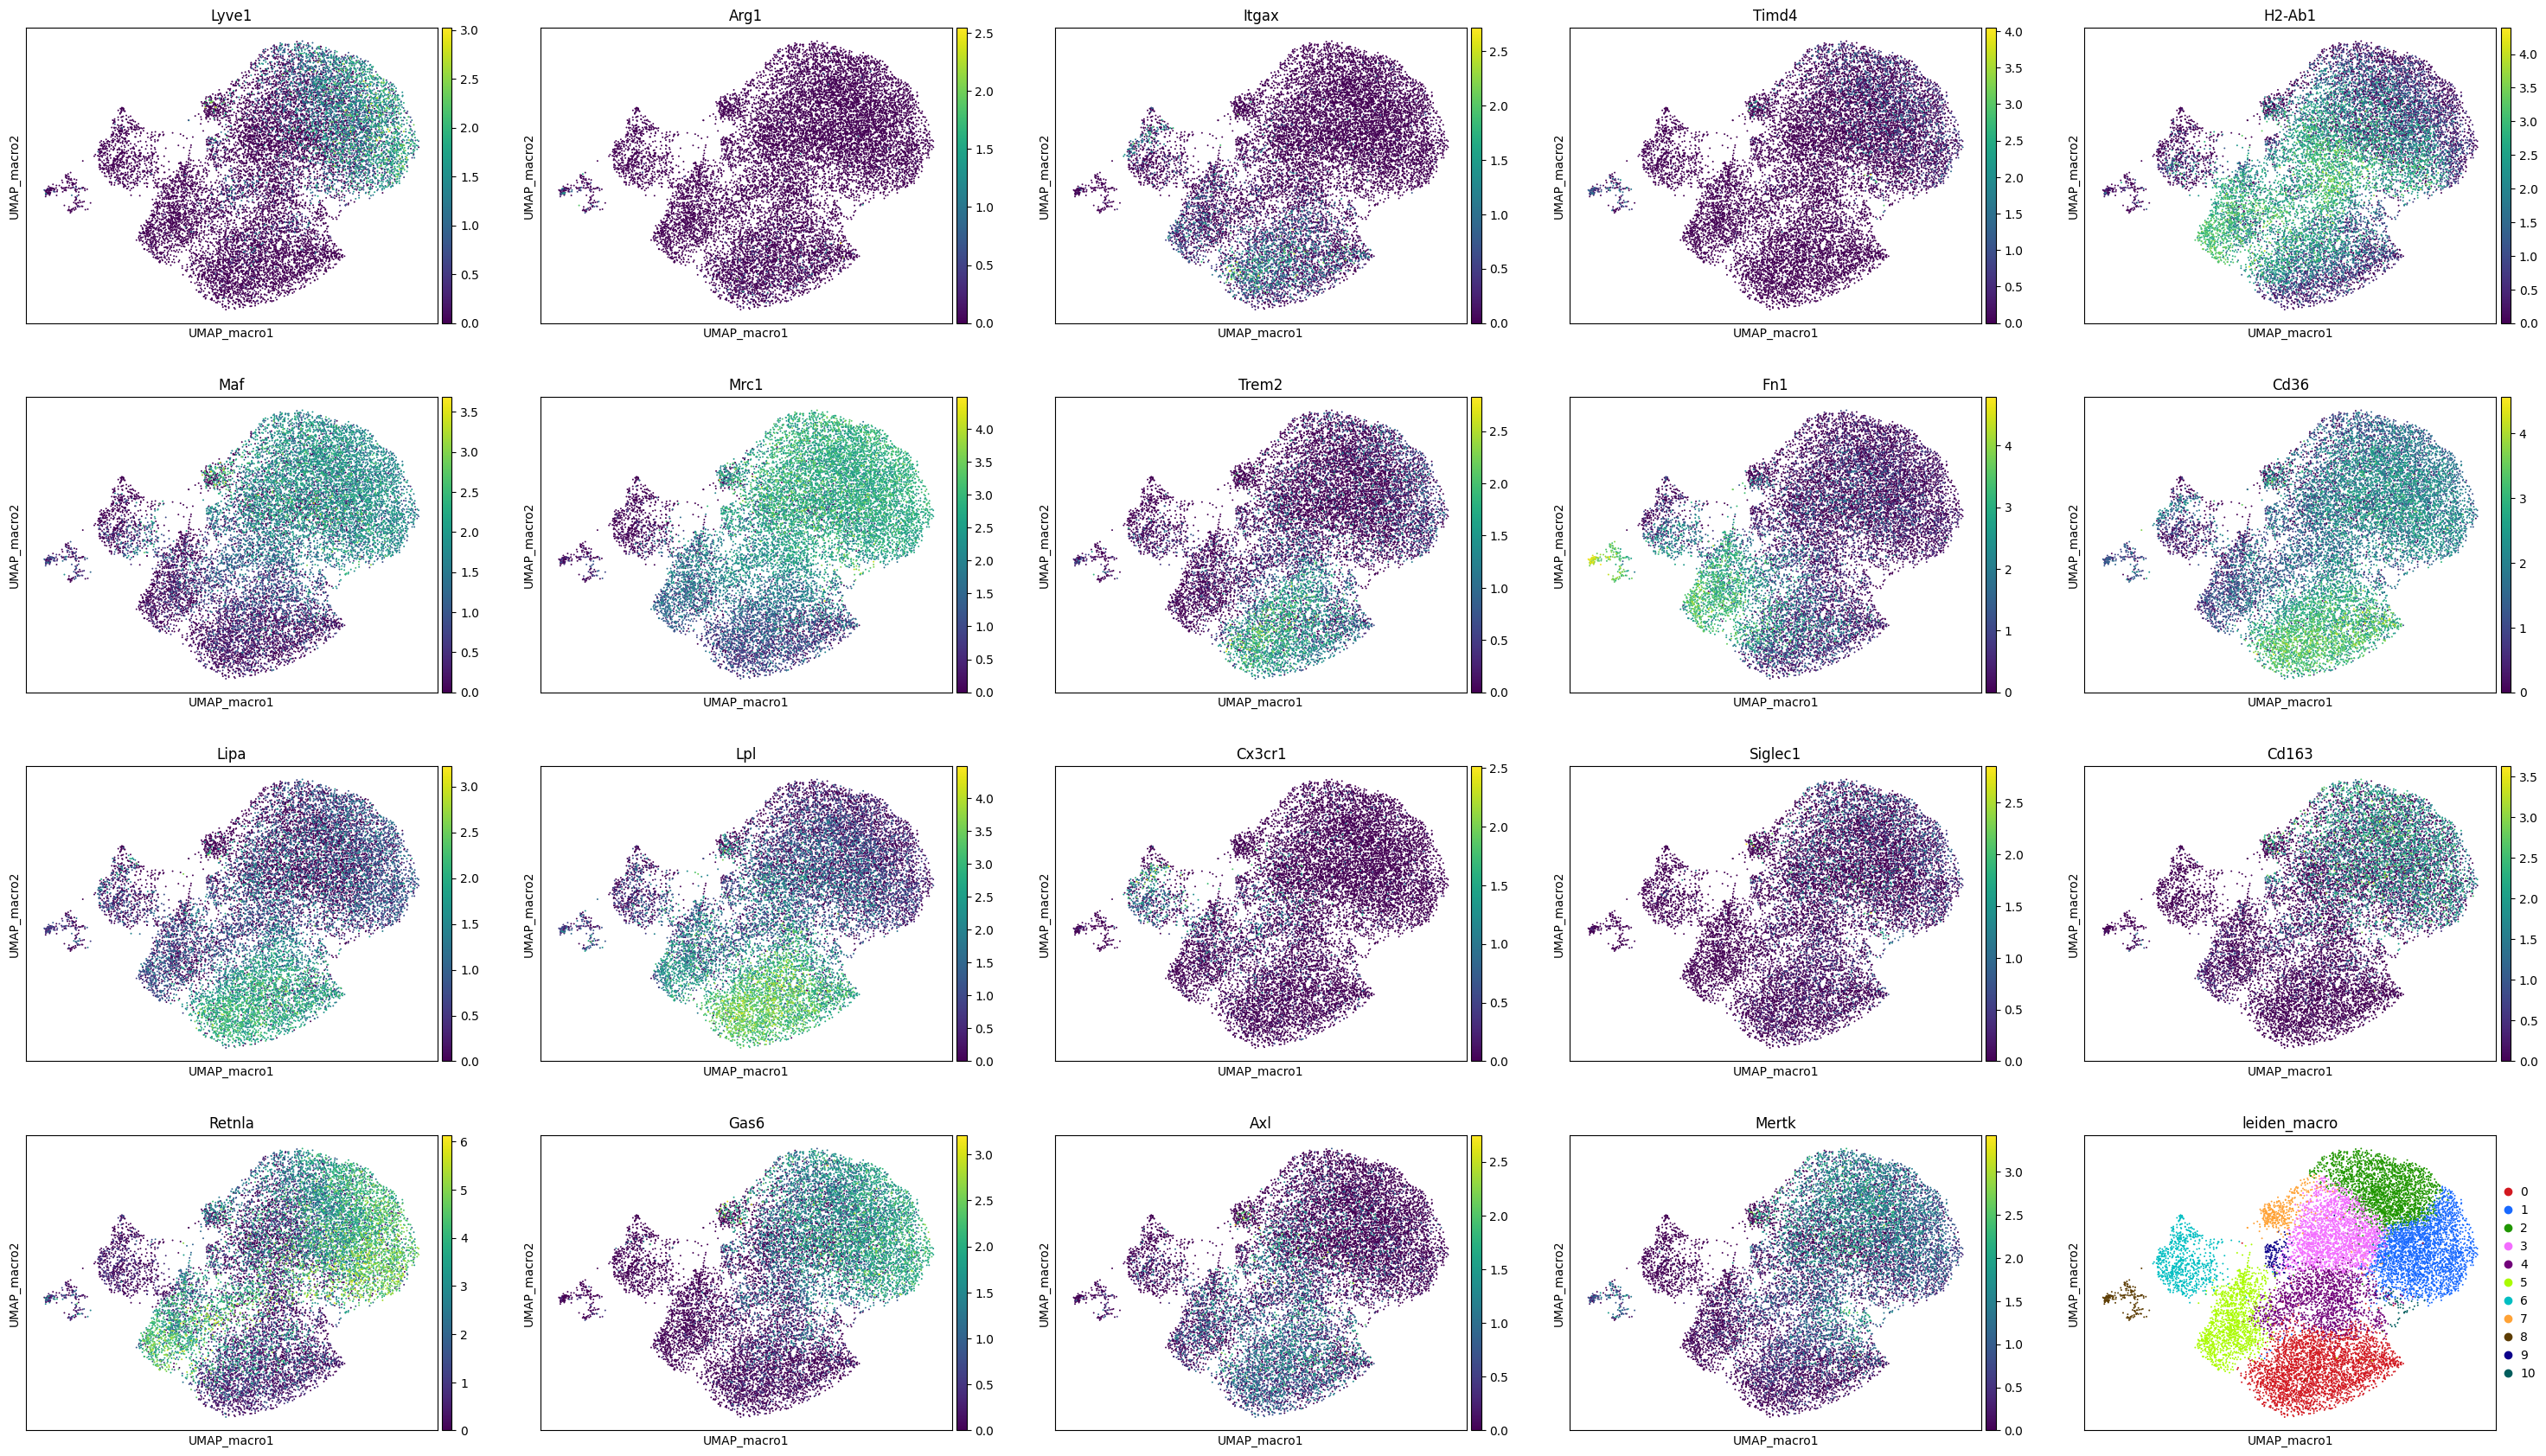

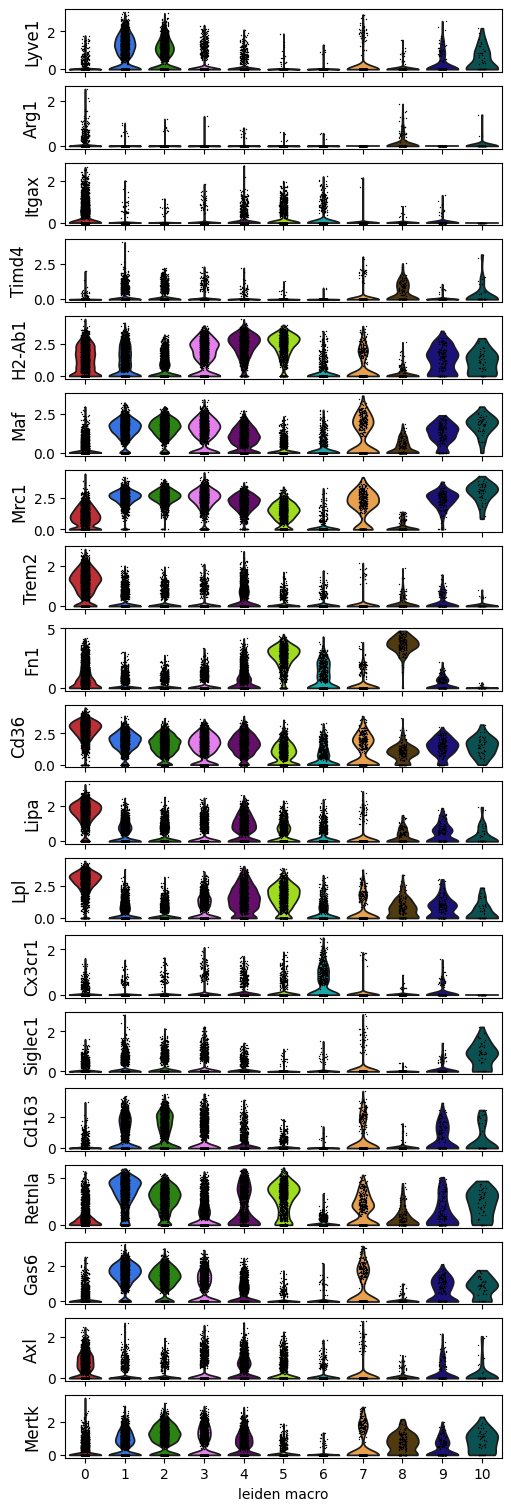

In [16]:
selected_markers = [
    "Lyve1",        # Lymphatic vessel endothelial hyaluronan receptor 1[2][3]
    "Arg1",         # Arginase 1[7][15]
    "Itgax",        # Integrin alpha X (CD11c)[16]
    "Timd4",        # T-cell immunoglobulin and mucin domain containing 4 (TIM-4)[9][17]
    "H2-Ab1",       # MHC class II (commonly H2-Ab1 for mouse)[10]
    "Maf",          # Maf bZIP transcription factor[11][19]
    "Mrc1",         # Mannose receptor C type 1 (CD206)[12][20]
    "Trem2",        # Triggering receptor expressed on myeloid cells 2[13][21]
    "Fn1",          # Fibronectin 1
    "Cd36",         # CD36 molecule
    "Lipa",         # Lipase A, lysosomal acid, cholesterol esterase
    "Lpl",          # Lipoprotein lipase
    "Cx3cr1",       # CX3C chemokine receptor 1
    "Siglec1",        # Also known as Cd169
    "Cd163",        # CD163 molecule
    "Retnla",       # Resistin-like alpha (RELMα)
    "Gas6",         # Growth arrest-specific 6
    "Axl",          # AXL receptor tyrosine kinase
    # "Tyro3",        # TYRO3 protein tyrosine kinase
    "Mertk"         # MERTK protein tyrosine kinase
]

sc.pl.embedding(adata_macros, basis="UMAP_macro", color=selected_markers+["leiden_macro"], layer='normalized', ncols=5)
# sc.pl.embedding(adata_macros, basis="UMAP_macro", color="leiden_macro_group", layer='normalized', ncols=5)
f = plt.figure(figsize=(5,15),layout="constrained")
cluster_violinplot(adata_macros, selected_markers, "leiden_macro_group",f)

#### DEGs

In [ ]:
# find DEGs
sc.tl.rank_genes_groups(adata_macros, groupby='leiden_macro_group', key_added="de_macro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')
f, ax = plt.subplots(1,1,figsize=(20,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_macros, groupby="leiden_macro_group", key='de_macro',
    standard_scale="var", n_genes=20, min_logfoldchange=2, ax=ax
)

sc.tl.rank_genes_groups(adata_macros, groupby='leiden_macro', key_added="de_macro_sub",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')
f, ax = plt.subplots(1,1,figsize=(30,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_macros, groupby="leiden_macro", key='de_macro_sub',
    standard_scale="var", n_genes=20, min_logfoldchange=2, ax=ax
)

# df = sc.get.rank_genes_groups_df(adata_macros, group=None, key="de_macro")

In [ ]:
df = sc.get.rank_genes_groups_df(adata_macros, group=None, key="de_macro_sub", pval_cutoff=0.01)
df = df[abs(df['logfoldchanges']) > 1]
df

In [ ]:
sc.pl.heatmap(adata_macros,df.names.unique(),"leiden_macro", layer="normalized", use_raw=False, cmap="RdBu_r",)

In [ ]:
# our custom markers

f = plt.figure(figsize=(50,10),layout="constrained")
sf = f.subfigures(1,5)
clusters = adata_macros.obs['leiden_macro_group'].cat.categories
# markers2 = ["Cx3cr1", "Mrc1", "Arg1", "Timd4", "Cd9", "Trem2"]
genes = [["Pecam1", "Fabp4", "Cdh5", "Cdh13", "Ptprb", "Adgrf5", "Mgll", "Etl4", "Gpihbp1", "Mecom"],
        ["F13a1", "Rbpj", "Mrc1", "Maf", "Slc9a3r2", "Ctss", "Gas6", "Serinc3", "Fcgr2b", "Ap2a2"],
        ["Lgals3", "Lipa", "Ctse", "Adam8", "Atp6v0d2", "Trem2", "Psap", "Plin2", "Mfsd12", "Ms4a6c"],
        ["Jarid2", "Klf2", "Gsr", "Ccr2", "Ifitm6", "Arhgap26", "Plcb1", "Itgal", "Itga4", "Fam49b"],
        ["Flnb", "Prg4", "Emilin2", "Thbs1", "Fn1", "Itga6", "Ssh2", "Alox15", "Ltbp1", "Itgam"]
]

for g,gene in enumerate(genes):
    cluster_violinplot(adata_macros, gene, "leiden_macro_group", sf[g])

##### HFD vs LFD

In [ ]:
hfd_macros = adata_macros[adata_macros.obs["Condition"] == 'HFD'].copy()
hfd_macros = hfd_macros[hfd_macros.obs['leiden_macro_group'].isin(['1','2','3','5'])] # remove 4 since there's only 1 cell
lfd_macros = adata_macros[adata_macros.obs["Condition"] == 'LFD'].copy()

In [ ]:
sc.tl.rank_genes_groups(hfd_macros, groupby='leiden_macro_group', key_added="de_macro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

# del hfd_macros.uns['dendrogram_leiden_macro_group']
f, ax = plt.subplots(1,1,figsize=(15,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    hfd_macros, groupby="leiden_macro_group", key='de_macro',
    standard_scale="var", n_genes=10, min_logfoldchange=2, ax=ax, title="HFD DEGs"
)

In [ ]:
sc.tl.rank_genes_groups(lfd_macros, groupby='leiden_macro_group', key_added="de_macro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

del lfd_macros.uns['dendrogram_leiden_macro_group']
f, ax = plt.subplots(1,1,figsize=(15,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    lfd_macros, groupby="leiden_macro_group", key='de_macro',
    standard_scale="var", n_genes=10, min_logfoldchange=2, ax=ax, title="LFD DEGs"
)

#### GSEA

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)


net['weight'] = 1
INFO:root:Network adjacency matrix has 3469 unique features and 50 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 50 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


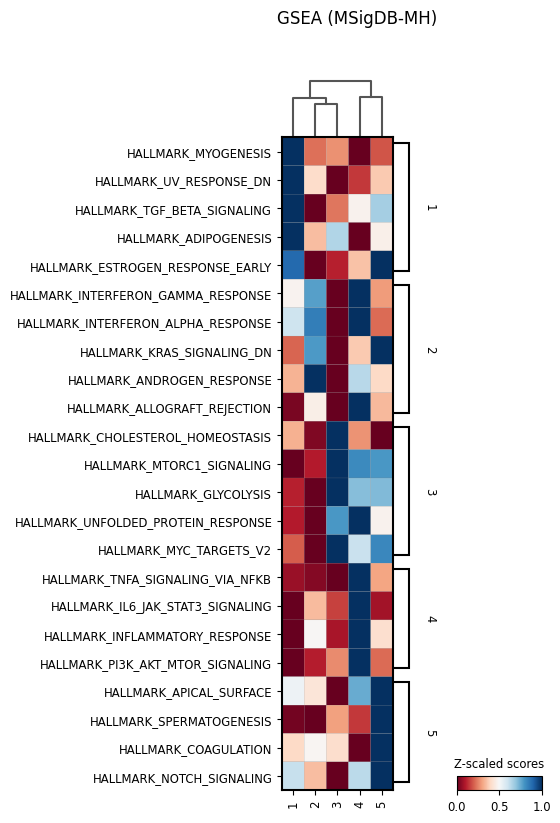

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 7363 unique features and 1605 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 1605 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


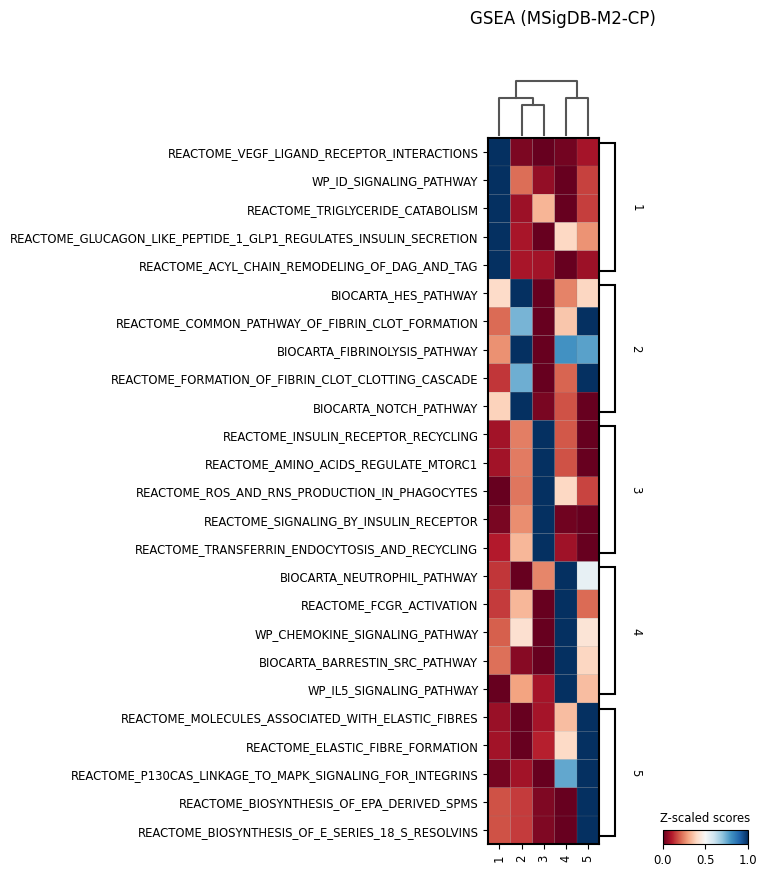

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 12952 unique features and 2000 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 2000 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


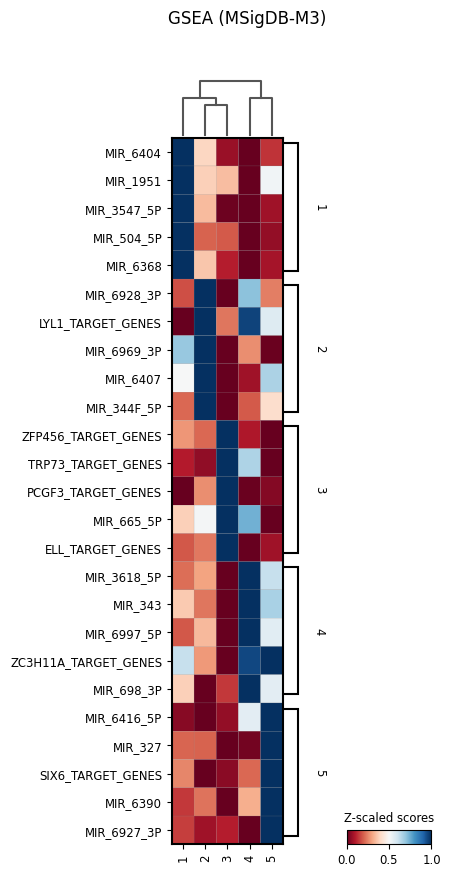

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 11764 unique features and 9300 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 9300 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


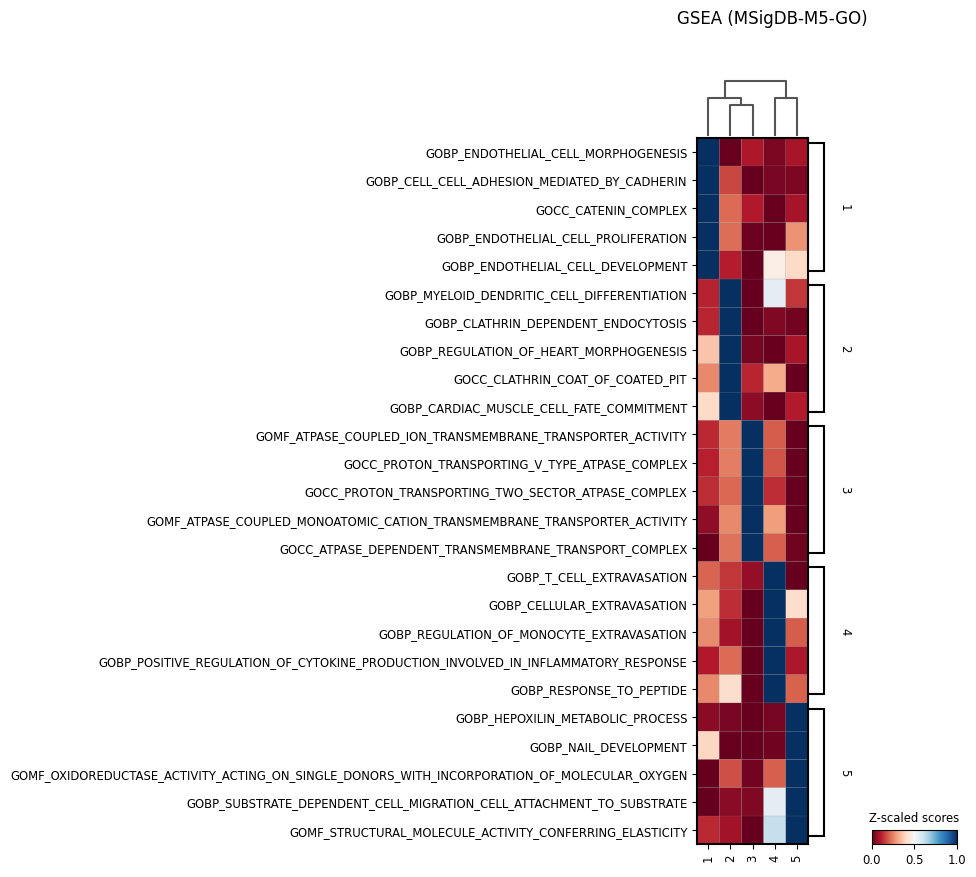

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 5626 unique features and 774 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 774 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


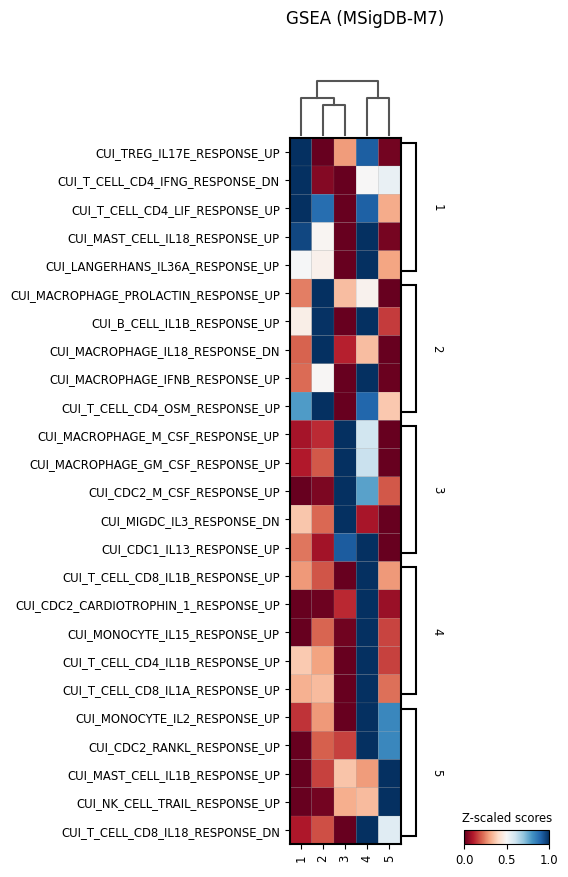

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 5626 unique features and 774 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 774 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


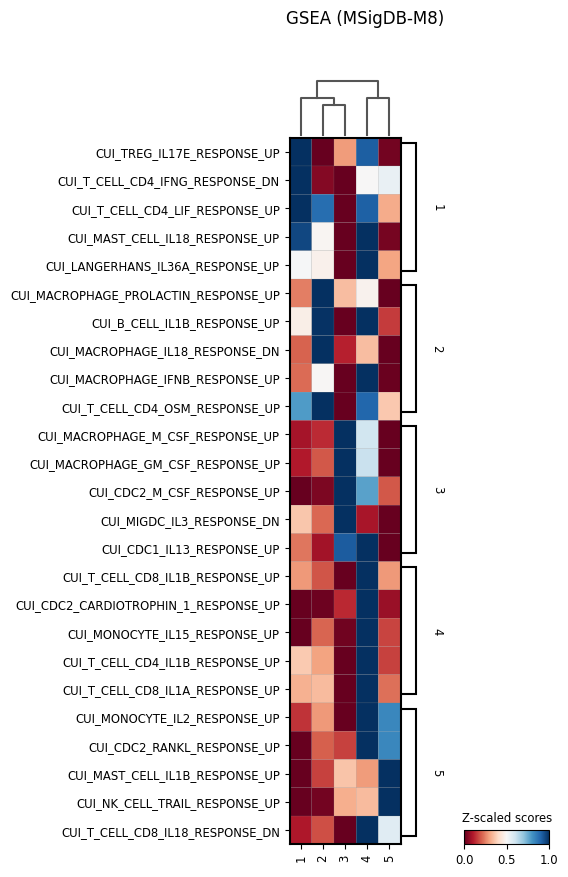

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
INFO:root:Network adjacency matrix has 4578 unique features and 646 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 646 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


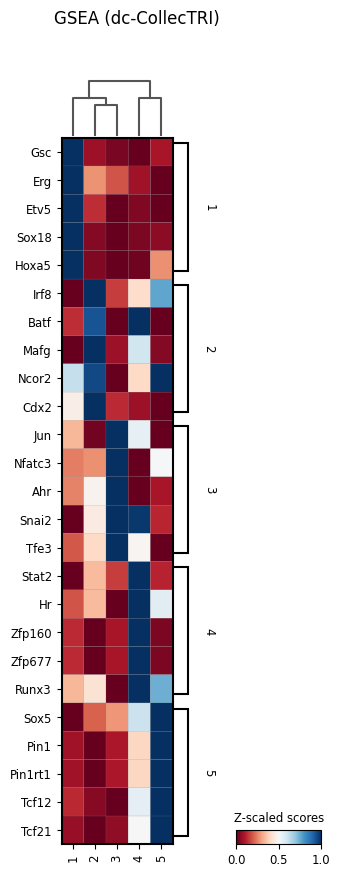

In [ ]:
name = "MSigDB-MH"
GSEA_dcULM(adata_macros, name, geneset_dir="mh.all.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "MSigDB-M2-CP"
GSEA_dcULM(adata_macros, name, geneset_dir="m2.cp.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "MSigDB-M3"
GSEA_dcULM(adata_macros, name, geneset_dir="m3.all.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "MSigDB-M5-GO"
GSEA_dcULM(adata_macros, name, geneset_dir="m5.go.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "MSigDB-M7"
GSEA_dcULM(adata_macros, name, geneset_dir="m7.all.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "MSigDB-M8"
GSEA_dcULM(adata_macros, name, geneset_dir="m8.all.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

name = "dc-CollecTRI"
GSEA_dcULM(adata_macros, name, geneset=dc.op.collectri(organism='mouse'))
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

INFO:root:ulm - Running ulm
INFO:root:Extracted omics mat with 2066 rows (observations) and 14407 columns (features)
net['weight'] = 1
INFO:root:Network adjacency matrix has 7794 unique features and 226 unique sources


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:ulm - fitting 226 univariate models of 14407 observations (targets) with 14405 degrees of freedom
INFO:root:ulm - adjusting p-values by FDR
INFO:root:ulm - done


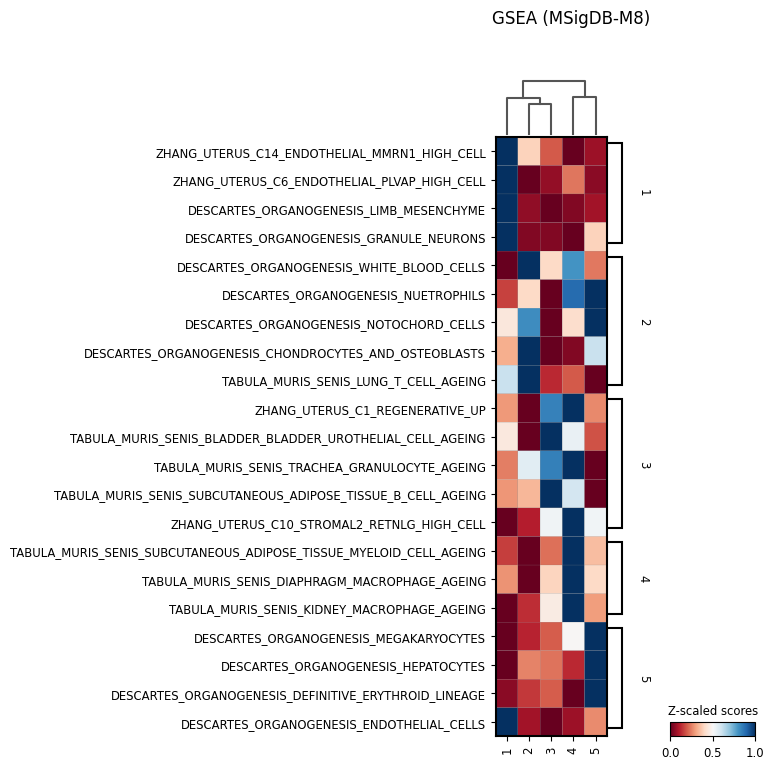

In [8]:
name = "MSigDB-M8"
GSEA_dcULM(adata_macros, name, geneset_dir="m8.all.v2025.1.Mm.symbols.gmt")
plot_gsea(adata_macros, f"GSEA ({name})", f"{name}_score_ulm", 'leiden_macro_group', 5, name)

In [ ]:
score = dc.pp.get_obsm(adata, key=f"{name}_score_ulm")
sc.pl.embedding(score, basis="LocalMAP", color=["Maf","cell_type","Condition"], title=["Maf (TF) GSEA enrichment","Cell Type","Condition"],
                cmap="RdBu_r", vcenter=0)

#### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros.write(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

In [4]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

## Fibroblasts

In [ ]:
# subset
adata_fibros = adata[adata.obs["cell_type"] == "Fibroblast"].copy()
del adata_fibros.uns, adata_fibros.varm, adata_fibros.obsp
sc.pp.filter_cells(adata_fibros, min_genes=200)
sc.pp.filter_genes(adata_fibros, min_cells=5)

# UMAP
sc.pp.neighbors(adata_fibros, use_rep = "integrated")
sc.tl.umap(adata_fibros, key_added='UMAP_fibro')

#LocalMAP
lm = LocalMAP()
adata_fibros.obsm["LocalMAP_fibro"] = lm.fit_transform(adata_fibros.obsm['integrated'])

In [ ]:
# integration check
f = plt.figure(figsize=(18,12), layout="constrained")
check_integration(adata_fibros, "Groups", f, embeddings=["UMAP_fibro", "LocalMAP_fibro"], nrow=2, ncol=2)

#### Clusters

In [ ]:
# cluster
recluster = False
groupname = "leiden_fibro"

if recluster is True:
    sc.tl.leiden(adata_fibros, resolution=0.5, key_added='leiden_fibro')
    order_obs(adata_fibros,"leiden_fibro",pd.Series([2,1,6,0,4,3,7,5]).astype(str))

# figure prep
cluster_c = color_gen(adata_fibros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "UMAP_fibro" # "LocalMAP_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
cluster_violinplot(adata_fibros, markers, groupname, sf[1])

#### Annotation

In [ ]:
# reannotate
adata_fibros.obs["leiden_fibro_group"] = adata_fibros.obs["leiden_fibro"].map(
    {'1' : 1, '3' : 1, '5' : 1,
     '0' : 2,
     '2' : 3,
     '4' : 4,
     }).astype(str)
order_obs(adata_fibros,"leiden_fibro_group",pd.Series(np.arange(1,5)).astype(str))

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_fibros, "Groups", "leiden_fibro_group", pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=False, ax=axs[0])
cluster_stackedbarplot(adata_fibros, "leiden_fibro_group", "Groups", pct=True, ax=axs[1])

In [ ]:
# figure prep
groupname = "leiden_fibro_group"
cluster_c = color_gen(adata_fibros.obs[groupname])
f = plt.figure(figsize=(25,15),layout="constrained")
sf = f.subfigures(1,2, width_ratios=[2, 1])

axs = sf[0].subplots(3,3)
gs = axs[0,0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_fibro" # "UMAP_fibro"
ax = sf[0].add_subplot(gs[:2,:])
sc.pl.embedding(adata_fibros, basis=embedding, color=[groupname], ax=ax, show=False,
                legend_loc='on data', legend_fontoutline=2, legend_fontsize=20, palette=cluster_c.to_list())
ax = sf[0].add_subplot(gs[2,0])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Groups'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,1])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Condition'], ax=ax, show=False, alpha=0.7)
ax = sf[0].add_subplot(gs[2,2])
sc.pl.embedding(adata_fibros, basis=embedding, color=['Sample Type'], ax=ax, show=False, alpha=0.7)

# Violin marker plots
markers = ["Pdgfra", "Dpp4", "Cd55", "F3", "Lpl"]
cluster_violinplot(adata_fibros, markers, groupname, sf[1])

#### DEGs

In [ ]:
# find DEGs
sc.tl.rank_genes_groups(adata_fibros, groupby='leiden_fibro_group', key_added="de_fibro",
                        use_raw=False, layer="normalized", 
                        method='wilcoxon')

# del adata_fibros.uns['dendrogram_leiden_fibro'], adata_fibros.uns['dendrogram_leiden_fibro_group']
f, ax = plt.subplots(1,1,figsize=(15,5),layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_fibros, groupby="leiden_fibro_group", key='de_fibro',
    standard_scale="var", n_genes=10, min_logfoldchange=2, ax=ax
)

df = sc.get.rank_genes_groups_df(adata_fibros, group=None, key="de_fibro")

#### GSEA

In [ ]:
# name = "mouse_CP"
# # geneset = dc.pp.read_gmt(os.path.join(REFDIR,"interactome", "m2.cp.v2025.1.Mm.symbols.gmt"))
# # dc.mt.ulm(data=adata_fibros, net=geneset, layer="normalized", verbose=True)
# # dc.mt.aucell(data=adata_fibros, net=geneset, layer="normalized", verbose=True)
# plot_gsea(adata_fibros, "score_ulm", "leiden_fibro_group", 10, False)

#### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros.write(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

# CCC

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '3_annotated', f'{annotation}.h5ad'))

annotation = "scDF-seuratV3-harmony-leiden_1.0-macro_leiden_0.5"
adata_macros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

annotation = "scDF-seuratV3-harmony-leiden_1.0-fibro_leiden_0.5"
adata_fibros = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  '4.0_subclustered', f'{annotation}.h5ad'))

### All Cells

In [ ]:
# ligand & receptor
cell2cell_interactions(adata, cores=CORES)
cell_interest = ["Fibroblast","Macrophage"]
cluster_c2c(adata, "ccc_aggregate_filtered", sources=cell_interest, targets=cell_interest,
              top_n=50, figsize=(15,10))

# Save as CSV
filtered = adata.uns["ccc_aggregate_filtered"].copy()
filtered_macfib = filtered[filtered.source.isin(cell_interest) & filtered.target.isin(cell_interest)]
# filtered_macfib.to_csv("filtered_macro_fibro_interactions")

### Fibros & Macros

In [ ]:
adata_fms = sc.concat([adata_fibros,adata_macros], join='outer')
adata_fms.raw = dc.pp.swap_layer(adata_fms, "counts")
adata_fms.obs['Subclusters'] = (pd.concat(['Fibroblast_' + adata_fms.obs['leiden_fibro_group'].dropna().astype(str),
                                           'Macrophage_' + adata_fms.obs['leiden_macro_group'].dropna().astype(str)])
                                .astype('category'))
order_obs(adata_fms, 'Subclusters',
          pd.concat([pd.Series('Fibroblast_' + adata_fms.obs['leiden_fibro_group'].cat.categories),
                     pd.Series('Macrophage_' + adata_fms.obs['leiden_macro_group'].cat.categories)]))
cell2cell_interactions(adata_fms, cell_group='Subclusters', key="ccc_FMs", cores=CORES)

In [ ]:
cluster_c2c(adata_fms, "ccc_FMs_filtered", top_n=100, figsize=(25,10))

### Save/Load

In [ ]:
# save
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata.write(os.path.join(DATADIR,'processed',study,'py',
                                  'cell_communication', f'{annotation}.h5ad'))

In [ ]:
# load
annotation = "scDF-seuratV3-harmony-leiden_1.0"
adata = sc.read_h5ad(os.path.join(DATADIR,'processed',study,'py',
                                  'cell_communication', f'{annotation}.h5ad'))

##### CellPhoneDB only

In [ ]:
from py.ccc import liana_mouse_resource

ccc_db = liana_mouse_resource()

# cellphoneDB only
cellphonedb(
    adata, groupby="cell_type", layer='normalized', use_raw=False, key_added="ccc_cellphoneDB",
    return_all_lrs=True, verbose=True, n_jobs=10, resource=ccc_db[["ligand", "receptor"]]
)
adata.uns["ccc_cellphoneDB"] = adata.uns["ccc_cellphoneDB"].merge(ccc_db[['ligand', 'receptor', 'db_sources']],
                                                                  left_on=["ligand_complex", "receptor_complex"],
                                                                  right_on=['ligand','receptor'],
                                                                  how='left')
print(np.sum(adata.uns["ccc_cellphoneDB"]["cellphone_pvals"] < 0.01))
adata.uns["ccc_cellphoneDB"]

##### CellChat only

In [ ]:
li.method.cellchat(
    adata, groupby="cell_type", layer='normalized', use_raw=False, key_added="ccc_cellchat",
    return_all_lrs=True, verbose=True, n_jobs=10, resource=ccc_db[["ligand", "receptor"]])
adata.uns["ccc_cellchat"] = adata.uns["ccc_cellchat"].merge(ccc_db[['ligand', 'receptor', 'db_sources']],
                                                                  left_on=["ligand_complex", "receptor_complex"],
                                                                  right_on=['ligand','receptor'],
                                                                  how='left')
adata.uns["ccc_cellchat"]